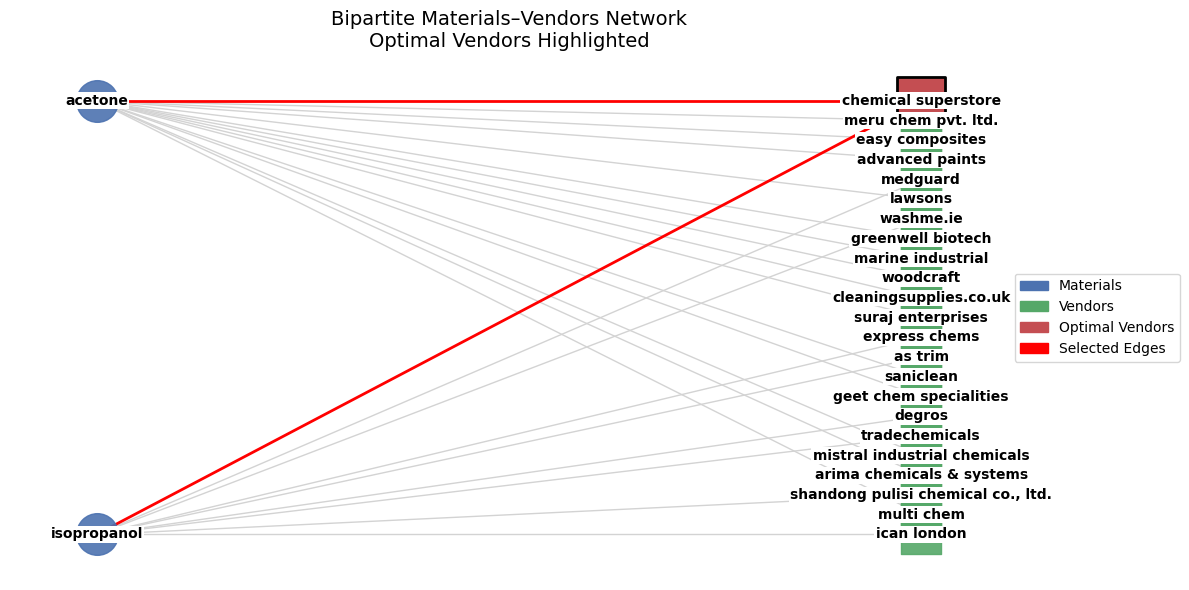

In [22]:
import json
import itertools
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === 1) Load JSON data for each material ===
material_files = {
    'isopropanol': 'isoprop_product_data.json',
    'acetone':     'acetone_product_data.json'
}

supply_specs = {}
for material, filename in material_files.items():
    with open(filename) as f:
        data = json.load(f)
    for vendor, entries in data.items():
        for info in entries.values():
            price = info.get('price', 0.0)
            score = info.get('match_score', 0.0)
            supply_specs[(material, vendor)] = {'price': price, 'match_score': score}

# === 2) Define query specs ===
query_specs = {
    'isopropanol': {'price': 10.0, 'match_score': 1.0},
    'acetone':     {'price': 20.0, 'match_score': 0.8}
}

# === 3) Compute BiRank and optimal subset ===
materials = list(query_specs.keys())
vendors   = sorted({v for (_, v) in supply_specs.keys()})

# Build supply map
supply_map = {v: set() for v in vendors}
for (m, v) in supply_specs:
    supply_map[v].add(m)

# Build W
M, V = len(materials), len(vendors)
mat_index = {m: i for i, m in enumerate(materials)}
vend_index = {v: j for j, v in enumerate(vendors)}
W = np.zeros((M, V))
for (m, v), specs in supply_specs.items():
    qdict = query_specs.get(m, {})
    if not qdict:
        continue
    keys = sorted(set(qdict) | set(specs))
    qvec = np.array([qdict.get(k, 0.0) for k in keys]).reshape(1, -1)
    vvec = np.array([specs.get(k, 0.0) for k in keys]).reshape(1, -1)
    W[mat_index[m], vend_index[v]] = cosine_similarity(qvec, vvec)[0, 0]

# BiRank
alpha = 0.85
f = np.ones(M) / M
h = np.ones(V) / V
for _ in range(100):
    h = alpha * W.T.dot(f) + (1 - alpha) * (np.ones(V)/V)
    h /= h.sum()
    f = alpha * W.dot(h) + (1 - alpha) * (np.ones(M)/M)
    f /= f.sum()

# Find minimal cover
all_mat = set(materials)
best_size, best_score, best_subset = V+1, -np.inf, None
for r in range(1, V+1):
    for subset in itertools.combinations(vendors, r):
        covered = set().union(*(supply_map[v] for v in subset))
        if covered == all_mat:
            total = sum(h[vend_index[v]] for v in subset)
            if r < best_size or (r == best_size and total > best_score):
                best_size, best_score, best_subset = r, total, subset
    if best_subset:
        break

# === 4) Build and plot graph ===
G = nx.Graph()
G.add_nodes_from(materials, bipartite=0)
G.add_nodes_from(vendors,   bipartite=1)
for (m, v) in supply_specs:
    G.add_edge(m, v)

pos = nx.bipartite_layout(G, materials)
plt.figure(figsize=(12, 6))

# Draw edges: non-optimal in light grey, optimal in bold red
all_edges = list(G.edges())
opt_edges = [(m, v) for (m, v) in all_edges if v in best_subset]
other_edges = [e for e in all_edges if e not in opt_edges]
nx.draw_networkx_edges(G, pos, edgelist=other_edges, edge_color='lightgray', width=1)
nx.draw_networkx_edges(G, pos, edgelist=opt_edges, edge_color='red', width=2)

# Draw nodes: materials and vendors, highlight optimal vendors
nx.draw_networkx_nodes(G, pos,
                       nodelist=materials, node_shape='o', node_color='#4C72B0',
                       node_size=900, alpha=0.9, label='Materials')
base_vendors = [v for v in vendors if v not in best_subset]
nx.draw_networkx_nodes(G, pos,
                       nodelist=base_vendors, node_shape='s', node_color='#55A868',
                       node_size=800, alpha=0.9, label='Vendors')
nx.draw_networkx_nodes(G, pos,
                       nodelist=best_subset, node_shape='s', node_color='#C44E52',
                       node_size=1200, alpha=1.0, edgecolors='black', linewidths=2,
                       label='Optimal Vendors')

# Draw labels with white text background for readability
for node, (x, y) in pos.items():
    plt.text(x, y, node,
             horizontalalignment='center', verticalalignment='center',
             fontsize=10, fontweight='bold',
             bbox=dict(facecolor='white', edgecolor='none', pad=1))

# Legend outside plot
handles = [
    mpatches.Patch(color='#4C72B0', label='Materials'),
    mpatches.Patch(color='#55A868', label='Vendors'),
    mpatches.Patch(color='#C44E52', label='Optimal Vendors'),
    mpatches.Patch(color='red', label='Selected Edges')
]
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Bipartite Materials–Vendors Network\nOptimal Vendors Highlighted", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
